# Introduction to Graph Neural Networks (GNNs) (Chapter 18)

---

This notebook marks the beginning of **Chapter 18: Graph Neural Networks for Capturing Dependencies in Graph-Structured Data**. It focuses on the fundamental operations of a GNN, moving away from grid-like data (images) or sequential data (text) to data represented as nodes and edges. The notebook builds a simple GNN from scratch to demonstrate how information is propagated across a graph.

### 1. Representing Graph Data 🕸️

Before building the network, the notebook establishes how to represent a graph numerically:

* **Adjacency Matrix ($A$):** A square matrix where $A_{ij} = 1$ if there is an edge between node $i$ and node $j$, and $0$ otherwise. This represents the structure/topology of the graph.
* **Node Feature Matrix ($X$):** A matrix of shape (Number of Nodes, Number of Features) containing the initial attributes for each node.
* **Graph Construction:** The notebook uses the **`networkx`** library to visualize small graphs and generate these matrices for testing.



### 2. The Graph Convolution Operation (Message Passing) 📩

The core of a GNN is the "Message Passing" mechanism. The notebook implements a basic version of the graph convolution layer:

* **Message Aggregation:** To update a node's representation, the model gathers features from its immediate neighbors. This is mathematically performed by multiplying the Adjacency Matrix with the Feature Matrix ($A \times X$).
* **The Self-Loop Trick:** A standard adjacency matrix doesn't include a node's own features in its update. The notebook adds an identity matrix to $A$ (denoted as $\tilde{A} = A + I$), ensuring that a node's new state is influenced by its current state plus its neighbors.
* **Normalization:** To prevent feature values from exploding (since nodes with many neighbors would have much larger sums), the notebook demonstrates degree-based normalization.



### 3. Building a Simple GNN Module 🧠

The notebook defines a custom PyTorch `nn.Module` for a GNN:

* **Layer Structure:** The model consists of multiple Graph Convolution layers. Each layer performs:
    1.  **Linear Transformation:** A standard weight matrix $W$ is applied to the features ($XW$).
    2.  **Neighborhood Summation:** The transformed features are propagated across the graph structure using the normalized adjacency matrix.
    3.  **Non-linear Activation:** A **ReLU** activation is applied.
* **Graph-Level Output (Readout):** For tasks where we need a single prediction for the *entire* graph (Graph Classification), the notebook implements a **Global Pooling** (or Readout) layer. This typically averages or sums all node features after the final convolution to create a fixed-size graph embedding.

### 4. Handling Batches of Graphs 📦

A unique challenge in GNNs is that different graphs have different numbers of nodes. The notebook demonstrates how to handle this efficiently:

* **Block Diagonal Adjacency:** Multiple small graphs are combined into one large "super-graph" where the individual adjacency matrices are placed along the diagonal.
* **Batch Vector:** A tracking vector is used to identify which node belongs to which original graph in the batch, allowing the Readout layer to aggregate nodes correctly for each separate graph.

This notebook provides the mathematical and structural bridge from standard deep learning to the specialized world of non-Euclidean, graph-structured data.

In [1]:
import networkx as nx
import numpy as np

In [2]:
G = nx.Graph()
blue, orange, green = '#1f77b4', '#ff7f0e', '#2ca02c'
G.add_nodes_from([
    (1, {'color': blue}),
    (2, {'color': orange}),
    (3, {'color': blue}),
    (4, {'color': green})
])

G.add_edges_from([(1, 2), (2, 3), (1, 3), (3, 4)])
A = np.asarray(nx.adjacency_matrix(G).todense())
print(A)

[[0 1 1 0]
 [1 0 1 0]
 [1 1 0 1]
 [0 0 1 0]]


In [3]:
def build_graph_color_label_repesentation(G, mapping_dict):
    one_hot_idxs = np.array(
        [mapping_dict[v] for v in nx.get_node_attributes(G, 'color').values()]
    )
    one_hot_encoding = np.zeros((one_hot_idxs.size, len(mapping_dict)))
    one_hot_encoding[np.arange(one_hot_idxs.size), one_hot_idxs] = 1

    return one_hot_encoding

In [4]:
X = build_graph_color_label_repesentation(
    G, {green: 0, blue: 1, orange: 2}
)
print(X)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


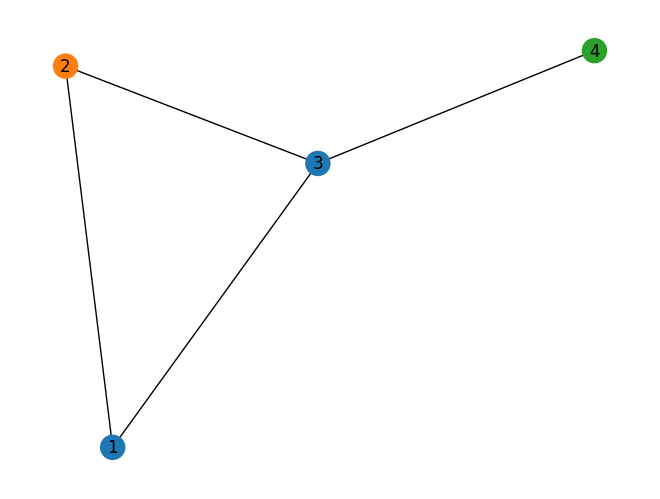

In [5]:
color_map = nx.get_node_attributes(G, 'color').values()
nx.draw(G, with_labels= True, node_color= color_map)

In [6]:
f_in, f_out = X.shape[1], 6
W_1 = np.random.rand(f_in, f_out)
W_2 = np.random.rand(f_in, f_out)
h = np.dot(X, W_1) + np.dot(np.dot(A, X), W_2)
print(h)

[[1.1975014  1.11998656 2.10786481 0.92313967 0.70955445 2.58422066]
 [0.71438386 2.1133107  2.30874773 1.17769047 0.85746974 2.27232108]
 [1.75487041 1.91690649 2.52498986 1.73844443 1.21371938 3.32931718]
 [0.27617516 1.12090771 1.54507872 0.50331116 0.98323315 1.80919541]]


In [7]:
import networkx as nx
import numpy as np
import math
import torch
from torch.nn.parameter import Parameter
import torch.nn.functional as F

In [43]:
class NodeNetwork(torch.nn.Module):
    def __init__(self, input_features):
        super().__init__()
        self.conv1 = BasicGraphConvolutionLayer(
            input_features, 32
        )
        self.conv2 = BasicGraphConvolutionLayer(
            32, 32
        )
        self.fc1 = torch.nn.Linear(32, 16)
        self.out_layer = torch.nn.Linear(16, 2)

    def forward(self, X, A, batch_mat):
        x = F.relu(self.conv1(X, A))
        x = F.relu(self.conv2(x, A))
        output = global_sum_pool(x, batch_mat)
        output = self.fc1(output)
        output = self.out_layer(output)
        return F.softmax(output, dim= 1)
        

In [46]:
class BasicGraphConvolutionLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.W1 = Parameter(
            torch.rand((in_channels, out_channels), dtype= torch.float32)
        )
        self.W2 = Parameter(
            torch.rand((in_channels, out_channels), dtype= torch.float32)
        )
        self.bias = Parameter(
            torch.zeros(out_channels, dtype= torch.float32)
        )

    def forward(self, X, A):
        potential_msgs = torch.mm(X, self.W2)
        propagated_msgs = torch.mm(A, potential_msgs)
        root_upadte = torch.mm(X, self.W1)
        output = root_upadte + propagated_msgs + self.bias

        return output

In [10]:
print('X Shape: ', X.shape)
print('A Shape: ', A.shape)

X Shape:  (4, 3)
A Shape:  (4, 4)


In [11]:
basic_layer = BasicGraphCovolutionLayer(3, 8)
out = basic_layer(
    X = torch.tensor(X, dtype= torch.float32),
    A = torch.tensor(A, dtype= torch.float32)
)
print('Output shape: ', out.shape)

Output shape:  torch.Size([4, 8])


In [13]:
def global_sum_pool(X, batch_mat):
    if batch_mat is None or batch_mat.dim() == 1:
        return torch.sum(X, dim= 0).unsqueeze(0)
    else:
        return torch.mm(batch_mat, X)

In [59]:
def get_batch_tensor(graph_sizes):
    batch_size = len(graph_sizes)
    total_len = sum(graph_sizes)
    starts = [sum(graph_sizes[:idx])
              for idx in range(batch_size)]
    stops = [starts[idx] + graph_sizes[idx] 
             for idx in range(batch_size)]
    batch_mat = torch.zeros([batch_size, total_len], dtype= torch.float32)
    for idx , starts_and_stops in enumerate(zip(starts, stops)):
        start = starts_and_stops[0]
        stop = starts_and_stops[1]
        batch_mat[idx, start:stop] = 1

    return batch_mat

In [80]:
def collate_graphs(batch):
    adj_mats = [graph['A'] for graph in batch]
    sizes = [A.size(0) for A in adj_mats]
    tot_size = sum(sizes)
    # create batch matrix
    batch_mat = get_batch_tensor(sizes)
    # combine feature matrices
    feat_mat = torch.cat([graph['X'] for graph in batch], dim= 0)
    # combine labels
    labels = torch.cat([graph['y'] for graph in batch], dim= 0)
    # combine adjacency matrices
    batch_adj = torch.zeros([tot_size, tot_size], dtype= torch.float32)
    accum = 0
    for adj in adj_mats:
        g_size = adj.shape[0]
        batch_adj[accum:accum+g_size, accum:accum+g_size] = adj
        accum += g_size
    repr_and_label = {
        'A': batch_adj,
        'X': feat_mat,
        'y': labels,
        'batch': batch_mat
    }

    return repr_and_label

In [81]:
def get_graph_dict(G, mapping_dict):
    A = torch.from_numpy(
        np.asarray(nx.adjacency_matrix(G).todense())).float()
    X = torch.from_numpy(
        np.asarray(build_graph_color_label_repesentation(
            G, mapping_dict))).float()
    y = torch.tensor([1, 0]).float()

    return {'A': A, 'X': X, 'y': y, 'batch': None}

In [82]:
blue, orange, green = '#1f77b4', '#ff7f0e', '#2ca02c'
mapping_dict = {green: 0, blue: 1, orange: 2}
G1 = nx.Graph()
G1.add_nodes_from([
    (1, {'color': blue}),
    (2, {'color': orange}),
    (3, {'color': blue}),
    (4, {'color': green})
])
G1.add_edges_from([(1, 2), (2, 3), (1, 3), (3, 4)])

In [83]:
G2 = nx.Graph()
G2.add_nodes_from([
    (1, {'color': green}),
    (2, {'color': green}),
    (3, {'color': orange}),
    (4, {'color': orange}),
    (5, {'color': blue})
])
G2.add_edges_from([(2, 3), (3, 4), (3, 1), (5, 1)])

In [84]:
G3 = nx.Graph()
G3.add_nodes_from([
    (1, {'color': orange}),
    (2, {'color': orange}),
    (3, {'color': green}),
    (4, {'color': green}),
    (5, {'color': blue}),
    (6, {'color': orange})
])
G3.add_edges_from([(2, 3), (3, 4), (3, 1), (5, 1), (2, 5), (6, 1)])

In [85]:
G4 = nx.Graph()
G4.add_nodes_from([
    (1, {'color': blue}),
    (2, {'color': blue}),
    (3, {'color': green})
])
G4.add_edges_from([(1, 2), (2, 3)])

In [86]:
graph_list = [get_graph_dict(graph ,mapping_dict) for graph in [G1, G2, G3, G4]]

In [87]:
from torch.utils.data import Dataset, DataLoader

class ExampleDataset(Dataset):
    def __init__(self, graph_list):
        self.graphs = graph_list
    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        mol_rep = self.graphs[idx]
        return mol_rep

In [88]:
ds = ExampleDataset(graph_list)
dataloader = DataLoader(
    ds, batch_size= 2,
    shuffle= False, collate_fn= collate_graphs
)

In [89]:
network_features = 3
net = NodeNetwork(network_features)
batch_results = []
for b in dataloader:
    batch_results.append(
        net(b['X'], b['A'], b['batch'].detach())
    )

In [91]:
G1_rep = ds[1]
G1_single = net(
    G1_rep['X'], G1_rep['A'], G1_rep['batch']
).detach()

In [94]:
G1_batch = batch_results[0][1]
torch.all(torch.isclose(G1_batch, G1_single))

tensor(True)